## Assignment 8: Image Classification Experiments

In this notebook, we're going to explore the use of a few different ways of setting up an image classification model. The images labels are available: http://cs231n.stanford.edu/tiny-imagenet-200.zip. The training set contains 500 images for each of 200 different classes. The validation set contains 50 images for each of the 200 classes. **You must download and unzip this file, putting the resulting directory in the same directory as your assignment notebook.**

Each of the images is a 64x64 pixel image (4096) pixels, each with a rgb value, resulting in 12288 values describing each image.

First, we're going to load images from the tiny-imagenet-200 folder into a *flattened* format that is suitable for training any of the scikit-learn classifier models, such as a tree or logistic regression.

Later, we'll take advantage of data loading functions included in PyTorch that will preserve the 2D-shape of images and load *batches* instead of the entire training or validation set all at once.

**This assignment has one, open-ended question where you are asked to investigate a change to a neural network architecture and see what happens. The code provided will show you how to load in the image data, train neural networks, and evaluate them.**


### Packages

You will need to install the `pytorch` and `torchvision` packages into your environment.

## Helper and Data Loading Functions

In [1]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torchvision
from sklearn.metrics import accuracy_score

def live_plot(loss, train_acc, valid_acc=None, figsize=(7,5), title=''):
    clear_output(wait=True)
    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.plot(loss, label='Training Loss', color='red')
    ax1.legend(loc='lower left')
    ax1.set_ylabel('Cross Entropy Loss')
    ax2 = ax1.twinx()
    ax2.plot(train_acc, label='Training Accuracy', color='green')
    if valid_acc is not None:
        ax2.plot(valid_acc, label='Validation Accuracy', color='blue')
    ax2.legend(loc='lower right')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_xlabel('Epoch')
    plt.title(title)
    plt.show()

def load_train_dataset():
    data_path = './tiny-imagenet-200/train/'
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.ToTensor()
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=32,
        num_workers=0,
        shuffle=True
    )
    return train_loader, train_dataset.class_to_idx

def load_valid_dataset(class_to_idx):
    data_path = './tiny-imagenet-200/val/images'
    label_file = open('./tiny-imagenet-200/val/val_annotations.txt', 'r')
    label_df = pd.read_csv(label_file, sep='\s+', header=None)
    label_df[1] = label_df[1].apply(lambda x : class_to_idx[x])
    valid_data = []
    for row in label_df.iterrows():
        image = Image.open(f'{data_path}/{row[1][0]}')
        image = torchvision.transforms.functional.to_tensor(image)
        label = row[1][1]
        valid_data.append((image, label))
    return valid_data

def load_data_np(batches=100):
    # Load a subsample of training data and all of the validation data into a flattened NumPy format.
    train_data_np = []
    train_labels = []
    batch_limit = batches
    for index, (data, label) in enumerate(train_dataset):
        for i in range(data.shape[0]):
            train_data_np.append(data[i].detach().numpy().flatten())
            train_labels.append(int(label[i].detach().numpy()))
        if index >= batch_limit - 1:
            break
    train_data_np = np.vstack(train_data_np)
    train_labels = np.array(train_labels)

    valid_data_np = []
    valid_labels = []
    for data, label in valid_dataset:
        if data.shape[0] < 3:
            data = torch.cat([data[0], data[0], data[0]], dim=0)  # Convert grayscale images into RGB format
        valid_data_np.append(data.detach().numpy().flatten())
        valid_labels.append(int(label))
    valid_data_np = np.vstack(valid_data_np)
    valid_labels = np.array(valid_labels)
    return train_data_np, train_labels, valid_data_np, valid_labels

<>:44: SyntaxWarning: invalid escape sequence '\s'
<>:44: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Boo\AppData\Local\Temp\ipykernel_26256\359687264.py:44: SyntaxWarning: invalid escape sequence '\s'
  label_df = pd.read_csv(label_file, sep='\s+', header=None)


In [2]:
# Load in a training and validation dataset from tiny-imagenet-200
# This file must be in the same folder as the /tiny-imagenet-200 for this to work

train_dataset, class_to_idx = load_train_dataset()
valid_dataset = load_valid_dataset(class_to_idx)

## Visualize Images and Labels

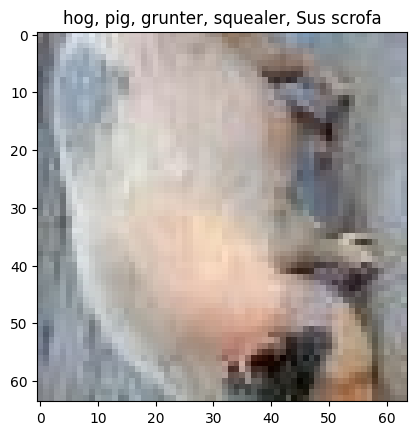

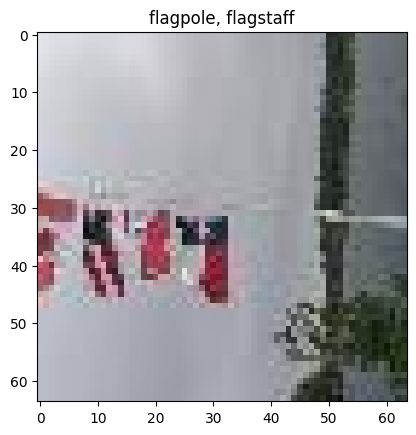

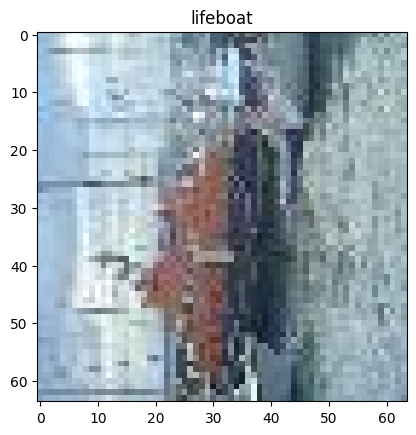

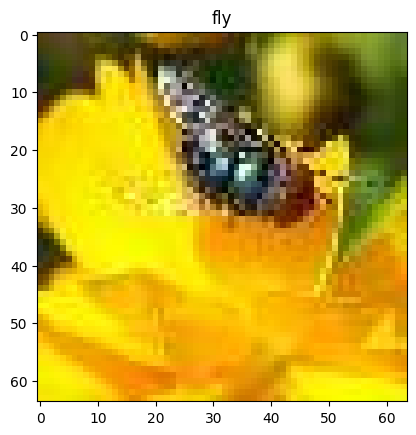

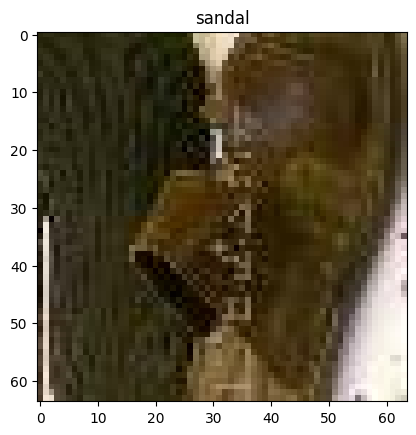

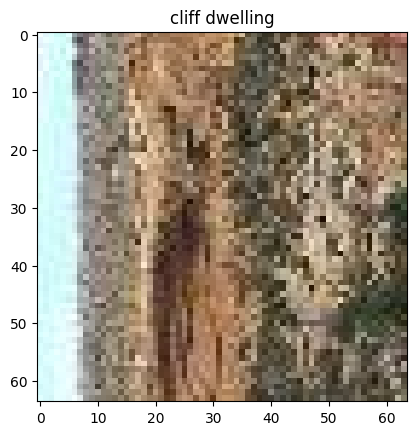

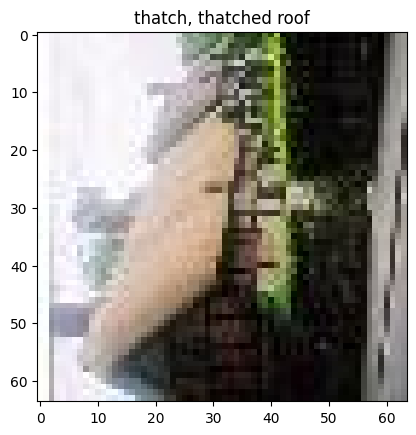

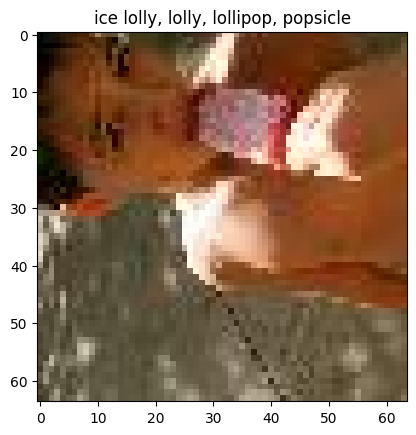

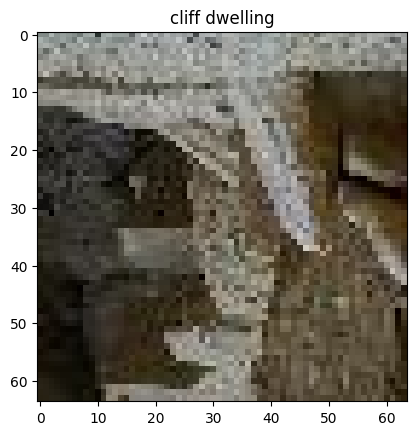

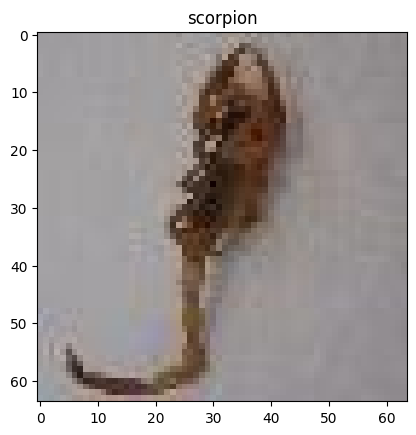

<Figure size 640x480 with 0 Axes>

In [3]:
import random
label_map = pd.read_csv("./tiny-imagenet-200/words.txt", delimiter='\t', header=None)
label_map = dict(zip(label_map[0], label_map[1]))
idx_to_class = {v:k for (k,v) in class_to_idx.items()}
# The train_dataset object organizes the training data into batches
# We grab the first batch and display a few images
index, (data, labels) = next(enumerate(train_dataset))
# Show ten random images
for image_index in random.sample(range(len(data)),10):
    image = data[image_index].detach().numpy().T
    label = labels.detach().numpy()[image_index]
    plt.imshow(image)
    plt.title(f"{label_map[idx_to_class[label]]}")
    plt.figure()
plt.show()

## Linear Model in PyTorch

In [8]:
# Load data into 'flattened' NumPy arrays
train_data_np, train_labels, valid_data_np, valid_labels = load_data_np(batches=20)
print(f"Training Data Shape: {train_data_np.shape}")
print(f"Training Labels Shape: {train_labels.shape}")
print(f"Validation Data Shape: {valid_data_np.shape}")
print(f"Validation Labels Shape: {valid_labels.shape}")

Training Data Shape: (640, 12288)
Training Labels Shape: (640,)
Validation Data Shape: (10000, 12288)
Validation Labels Shape: (10000,)


In [9]:
class LinearModel(torch.nn.Module):
    
    def __init__(self, input_size, num_classes):
        
        super().__init__()
        
        # Neural Network Architecture
        self.dense1 = torch.nn.Linear(in_features=num_features, out_features=num_classes)
        self.activation = torch.nn.LogSigmoid()
    
    def forward(self, X):
        X = self.dense1(X)
        X = self.activation(X)
        return X

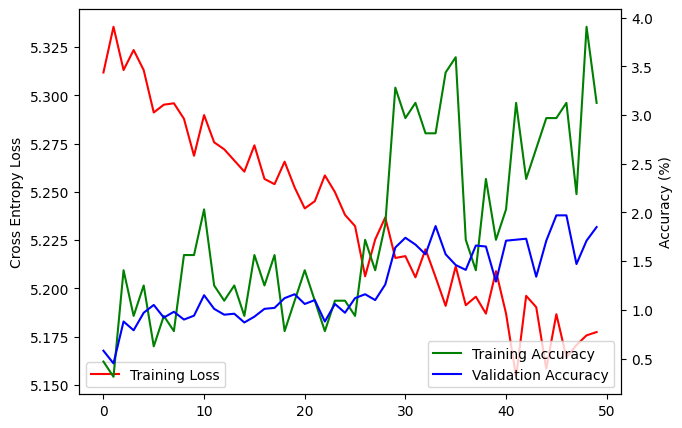

In [10]:
batch_limit = 20

# Load data into 'flattened' NumPy arrays
train_data_np, train_labels, valid_data_np, valid_labels = load_data_np(batches=batch_limit)

batch_size = 32
num_features = 64*64*3
num_classes = 200
max_iter = 50
model = LinearModel(num_features, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()

loss_list = []
accuracy_list = []
valid_list = []

for i in range(max_iter):
    epoch_loss = 0
    for index, (data, label) in enumerate(train_dataset):
        data = data.view(batch_size, -1)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(input=y_pred, target=label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Batch loss ({index+1}/{batch_limit}): {loss.item()}", end='\r')
        if index >= batch_limit -1:
            break
    with torch.no_grad():
        loss_list.append(epoch_loss/batch_limit)
        y_pred = model.forward(torch.Tensor(train_data_np.reshape(-1, num_features)))
        y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
        accuracy_list.append(accuracy_score(y_true=train_labels, y_pred=y_pred)*100)
        y_pred_val = model.forward(torch.Tensor(valid_data_np.reshape(-1, num_features)))
        y_pred_val = torch.argmax(y_pred_val, dim=1).detach().numpy()
        valid_list.append(accuracy_score(y_true=valid_labels, y_pred=y_pred_val)*100)
        # print(f"Loss at epoch {i}: {loss.item():.4f}\tAccuracy: {accuracy_list[-1]*100:.2f}%", end='\r')
        live_plot(np.array(loss_list), np.array(accuracy_list), valid_list) 

## Linear Model In PyTorch - 10x Training Data

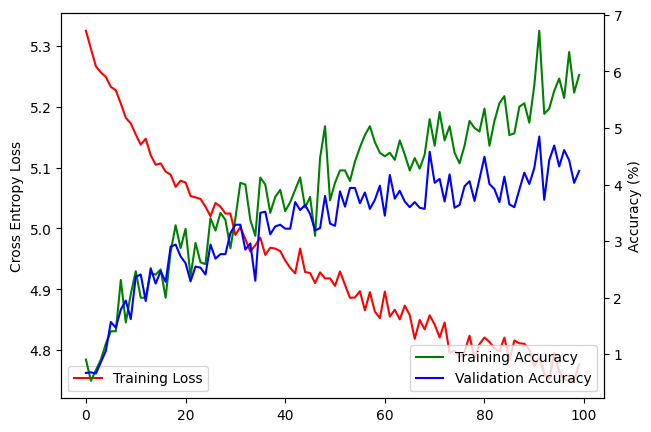

In [16]:
batch_limit = 100

# Load data into 'flattened' NumPy arrays
train_data_np, train_labels, valid_data_np, valid_labels = load_data_np(batches=batch_limit)

batch_size = 32
num_features = 64*64*3
num_classes = 200
max_iter = 100
model = LinearModel(num_features, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()

loss_list = []
accuracy_list = []
valid_list = []

for i in range(max_iter):
    epoch_loss = 0
    for index, (data, label) in enumerate(train_dataset):
        data = data.view(batch_size, -1)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(input=y_pred, target=label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Batch loss ({index+1}/{batch_limit}): {loss.item()}", end='\r')
        if index >= batch_limit -1:
            break
    with torch.no_grad():
        loss_list.append(epoch_loss/batch_limit)
        y_pred = model.forward(torch.Tensor(train_data_np.reshape(-1, num_features)))
        y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
        accuracy_list.append(accuracy_score(y_true=train_labels, y_pred=y_pred)*100)
        y_pred_val = model.forward(torch.Tensor(valid_data_np.reshape(-1, num_features)))
        y_pred_val = torch.argmax(y_pred_val, dim=1).detach().numpy()
        valid_list.append(accuracy_score(y_true=valid_labels, y_pred=y_pred_val)*100)
        # print(f"Loss at epoch {i}: {loss.item():.4f}\tAccuracy: {accuracy_list[-1]*100:.2f}%", end='\r')
        live_plot(np.array(loss_list), np.array(accuracy_list), valid_list) 

## Nonlinear Neural Network With One Hidden Layer

In [12]:
train_data_np, train_labels, valid_data_np, valid_labels = load_data_np(batches=200)
print(f"Training Data Shape: {train_data_np.shape}")
print(f"Training Labels Shape: {train_labels.shape}")
print(f"Validation Data Shape: {valid_data_np.shape}")
print(f"Validation Labels Shape: {valid_labels.shape}")

Training Data Shape: (6400, 12288)
Training Labels Shape: (6400,)
Validation Data Shape: (10000, 12288)
Validation Labels Shape: (10000,)


In [13]:
class NonLinearModel(torch.nn.Module):
    
    def __init__(self, input_size, num_classes):
        
        super().__init__()
        
        # Neural Network Architecture
        self.dense1 = torch.nn.Linear(in_features=num_features, out_features=400)
        self.activation1 = torch.nn.LogSigmoid()
        self.dense2 = torch.nn.Linear(in_features=400, out_features=num_classes)
        self.activation2 = torch.nn.LogSigmoid()
        
    def forward(self, X):
        X = self.dense1(X)
        X = self.activation1(X)
        X = self.dense2(X)
        X = self.activation2(X)
        return X

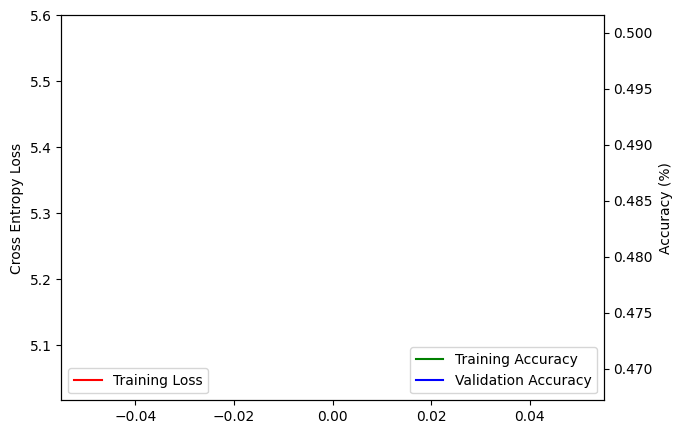

KeyboardInterrupt: 

In [ ]:
batch_limit = 100
batch_size = 32
num_features = 64*64*3
num_classes = 200
max_iter = 100
model = NonLinearModel(num_features, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()

loss_list = []
accuracy_list = []
valid_list = []

for i in range(max_iter):
    epoch_loss = 0
    for index, (data, label) in enumerate(train_dataset):
        data = data.view(batch_size, -1)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(input=y_pred, target=label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Batch loss ({index+1}/{batch_limit}): {loss.item()}", end='\r')
        if index >= batch_limit -1:
            break
    with torch.no_grad():
        loss_list.append(epoch_loss/batch_limit)
        y_pred = model.forward(torch.Tensor(train_data_np.reshape(-1, num_features)))
        y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
        accuracy_list.append(accuracy_score(y_true=train_labels, y_pred=y_pred)*100)
        y_pred_val = model.forward(torch.Tensor(valid_data_np.reshape(-1, num_features)))
        y_pred_val = torch.argmax(y_pred_val, dim=1).detach().numpy()
        valid_list.append(accuracy_score(y_true=valid_labels, y_pred=y_pred_val)*100)
        # print(f"Loss at epoch {i}: {loss.item():.4f}\tAccuracy: {accuracy_list[-1]*100:.2f}%", end='\r')
        live_plot(np.array(loss_list), np.array(accuracy_list), valid_list) 


## Convolutional Neural Network in PyTorch

In [9]:
train_data_np, train_labels, valid_data_np, valid_labels = load_data_np(batches=200)
print(f"Training Data Shape: {train_data_np.shape}")
print(f"Training Labels Shape: {train_labels.shape}")
print(f"Validation Data Shape: {valid_data_np.shape}")
print(f"Validation Labels Shape: {valid_labels.shape}")

Training Data Shape: (6400, 12288)
Training Labels Shape: (6400,)
Validation Data Shape: (10000, 12288)
Validation Labels Shape: (10000,)


In [10]:
class ConvNet(torch.nn.Module):
     
    def __init__(self, h, w, outputs):
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.conv3 = torch.nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = torch.nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = torch.nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = torch.nn.functional.relu(self.bn1(self.conv1(x)))
        x = torch.nn.functional.relu(self.bn2(self.conv2(x)))
        x = torch.nn.functional.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))


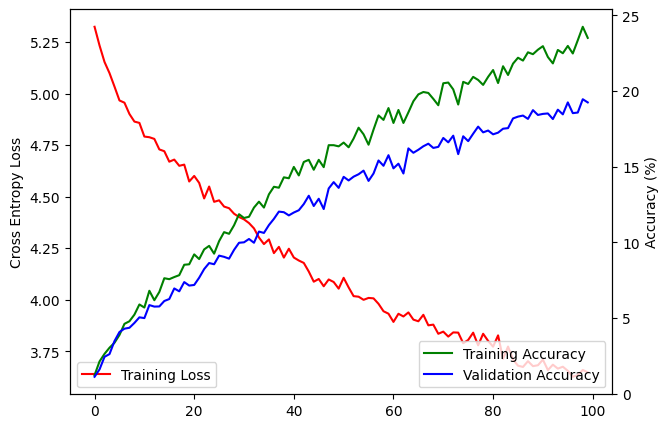

In [ ]:
batch_limit = 100
num_features = train_data_np[0].shape  # (64, 64, 3)
num_classes = 200
max_iter = 100
model = ConvNet(64, 64, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()

loss_list = []
accuracy_list = []
valid_list = []

for i in range(max_iter):
    epoch_loss = 0
    for index, (data, label) in enumerate(train_dataset):
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(input=y_pred, target=label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Batch loss ({index+1}/{batch_limit}): {loss.item()}", end='\r')
        if index >= batch_limit -1:
            break
    with torch.no_grad():
        loss_list.append(epoch_loss/batch_limit)
        y_pred = model.forward(torch.Tensor(train_data_np.reshape(-1, 3, 64, 64)))
        y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
        accuracy_list.append(accuracy_score(y_true=train_labels, y_pred=y_pred)*100)
        y_pred_val = model.forward(torch.Tensor(valid_data_np.reshape(-1, 3, 64, 64)))
        y_pred_val = torch.argmax(y_pred_val, dim=1).detach().numpy()
        valid_list.append(accuracy_score(y_true=valid_labels, y_pred=y_pred_val)*100)
        #print(f"Loss at epoch {i}: {loss.item():.4f}\tAccuracy: {accuracy_list[-1]*100:.2f}%", end='\r')
        live_plot(np.array(loss_list), np.array(accuracy_list), valid_list) 


## Assignment

Think about a modification to one of the above models you would like to make. You could decide to change the data preparation or splitting, the model architecture, loss function, learning algorithm, or any associated paramter. Implement an experiment that enables you to evaluate the impact of your modification. Make sure that your experiment is only studying the effects of one change. For example, you could compare the learning progress of a neural network model with one hidden layer vs. two hidden layers. In this case, you should make sure to use exactly the same training and validation datasets, the same loss function, and the same learning algorithm.

For each experimental condition, you can use the provided code to generate a learning progress plot, but feel free to explore other tools for evaluation, such as a [confusion matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py). This would be especially helpful to understand in what way your model is making classification errors.

**For submission**, *describe both the model you are starting (control) with* and the *modification you are evaluating (experimental).* What effect do you think your modification will have on training? On overall model performance? Next give a short description of what data you will use in your experiments (e.g. how many images, their format, and how many classes). Then, give a summary of results, clearly indicating the experimental condition to which they belong (i.e. control or experimental).

Comment on your results. Did your modification improve your image classifier? What evidence do you have to support this? Based on your observations or any other sources, what additional changes do you think could further improve your model? Do you think the training data you used contained sufficient training examples for your model to generalize well? Justify your claim.

Format your sumbission as a single Jupyter Notebook *and* corresponding PDF file. Use OWL to submit your assignment. Keep your submission brief: a single page (or equivalent) submission should be adequate.

### Notes

* Depending on your computer's hardware, you may need to scale back your experiments. You can try reducing the number of training iterations, the size of your training set, or the size of your model architecture. Just focus on creating a controlled experiment and explain that you had to use less data. 
* Along these lines, don't run experiments that will take too long to run. Test your experiments on a small number of training iterations (5 or so) to get a sense of how long each iteration takes. Even with relatively small training sets, it could take a few hours for model training to finish.

# Your Response

## What model are you starting with?

#### Explain in a short paragraph which of the models (and training strategies) above you will use for your comparison.

I will be evaluating Convolutinal Neural Network

## What modification are you making? Why?

#### Explain in a short paragraph what modification(s) you are making to the learning model, and briefly explain why you are making those modifications. (For example: Did you hear somewhere that it would help? Do you have a theoretical reason for the modification? Do you think learning might be faster? Do you think performance might be higher?)

I will be adding more filters in (self.conv) of the original CNN. Orignally, it had up to 32 filters and I will be increasing up to 128 filters. In class, we discussed how these filters in layers allow capturing and learning patterns from the input images. With that idea, I am assuming increased number of fiilter (4 times the original amount) within each layer will allow the model to detect richer context of underlying patterns in each training images. Thus, I am theorising that having more filters will improve the accuracy of the model in predicting testing sets. However, with increase in complexity within the layers, I am also expecting the performance to be slower.

## What data will you use?

#### Will use use the whole dataset or just a subset? Are you restricting the possible classes?

For the sake of performance, I will only be using batch size of 100 for both models. I will use all 200 clases for both models. For fair comaprison, the training and testing sets will be same for both model.

## Summary of results and your conclusions

#### Summarize what happened when you ran your experiment. Explain whether you found the result surprising or not. Explain the implications of your findings. (For example, is your modification better? Worse? Better but slower to train? Worse but faster?)

# Your code below

In [12]:
class ConvNet(torch.nn.Module):
     
    def __init__(self, h, w, outputs):
        super(ConvNet, self).__init__()
        #increased filter up to 128
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=5, stride=2)
        self.bn1 = torch.nn.BatchNorm2d(32)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=5, stride=2)
        self.bn2 = torch.nn.BatchNorm2d(64)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=5, stride=2)
        self.bn3 = torch.nn.BatchNorm2d(128)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 128 #edited for higher filter value
        self.head = torch.nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = torch.nn.functional.relu(self.bn1(self.conv1(x)))
        x = torch.nn.functional.relu(self.bn2(self.conv2(x)))
        x = torch.nn.functional.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

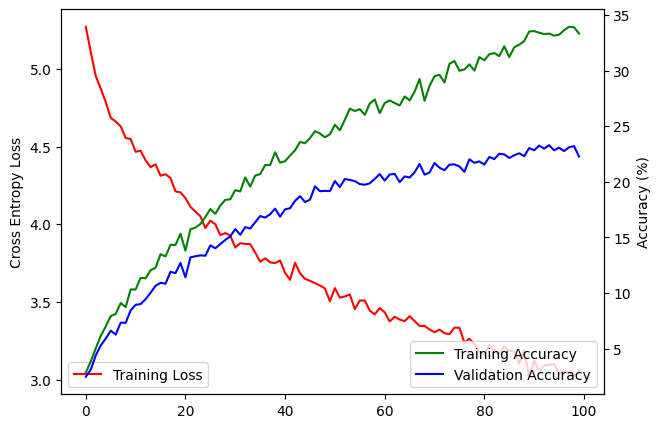

In [13]:
batch_limit = 100
num_features = train_data_np[0].shape  # (64, 64, 3)
num_classes = 200
max_iter = 100
model = ConvNet(64, 64, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()

loss_list = []
accuracy_list = []
valid_list = []

for i in range(max_iter):
    epoch_loss = 0
    for index, (data, label) in enumerate(train_dataset):
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(input=y_pred, target=label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Batch loss ({index+1}/{batch_limit}): {loss.item()}", end='\r')
        if index >= batch_limit -1:
            break
    with torch.no_grad():
        loss_list.append(epoch_loss/batch_limit)
        y_pred = model.forward(torch.Tensor(train_data_np.reshape(-1, 3, 64, 64)))
        y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
        accuracy_list.append(accuracy_score(y_true=train_labels, y_pred=y_pred)*100)
        y_pred_val = model.forward(torch.Tensor(valid_data_np.reshape(-1, 3, 64, 64)))
        y_pred_val = torch.argmax(y_pred_val, dim=1).detach().numpy()
        valid_list.append(accuracy_score(y_true=valid_labels, y_pred=y_pred_val)*100)
        #print(f"Loss at epoch {i}: {loss.item():.4f}\tAccuracy: {accuracy_list[-1]*100:.2f}%", end='\r')
        live_plot(np.array(loss_list), np.array(accuracy_list), valid_list) 